<a href="https://colab.research.google.com/github/lletridung/baitapai/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense,  Input, Conv2D, Activation, multiply
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D, Dropout, Embedding
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Reshape

In [45]:

#tạo quyền truy cập với google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# đọc dữ liệu từ file csv
df = pd.read_csv('/content/drive/MyDrive/dataset/Dữ liệu Lịch sử VNM 2013_2023.csv')

# Xóa hai dòng "KL" và "Thay đổi %" từ DataFrame dataSet
df = df.drop(columns=["KL", "% Thay đổi"])

# Hiển thị lại DataFrame sau khi xóa
print(df)

            Ngày  Đóng cửa    Mở cửa  Cao nhất Thấp nhất
0     21/07/2023  73,500.0  72,500.0  75,000.0  72,400.0
1     20/07/2023  72,700.0  72,600.0  72,900.0  72,300.0
2     19/07/2023  72,600.0  72,500.0  73,000.0  72,400.0
3     18/07/2023  72,400.0  72,500.0  72,600.0  72,200.0
4     17/07/2023  72,300.0  73,000.0  73,600.0  72,200.0
...          ...       ...       ...       ...       ...
2500  16/07/2013  96,528.0  95,139.0  97,222.0  95,139.0
2501  15/07/2013  95,139.0  95,139.0  95,833.0  94,444.0
2502  12/07/2013  95,139.0  94,444.0  95,139.0  93,750.0
2503  11/07/2013  94,444.0  94,444.0  95,139.0  93,750.0
2504  10/07/2013  94,444.0  95,139.0  95,833.0  94,444.0

[2505 rows x 5 columns]


In [47]:
#định dạng cấu trúc thời gian
df["Ngày"] = pd.to_datetime(df.Ngày,format="%d/%m/%Y")


#kích thước dữ liệu
df.shape


#dữ liệu 5 dòng đầu
df.head()


#xác định kiểu dữ liệu
df.info()


#mô tả bộ dữ liệu
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ngày       2505 non-null   datetime64[ns]
 1   Đóng cửa   2505 non-null   object        
 2   Mở cửa     2505 non-null   object        
 3   Cao nhất   2505 non-null   object        
 4   Thấp nhất  2505 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 98.0+ KB


<ipython-input-47-264c29f08fac>:18: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Ngày,Đóng cửa,Mở cửa,Cao nhất,Thấp nhất
count,2505,2505,2505,2505,2505
unique,2505,1250,1223,1300,1271
top,2023-07-21 00:00:00,"96,528.0","97,222.0","98,611.0","96,528.0"
freq,1,34,33,34,42
first,2013-07-10 00:00:00,NaN,NaN,NaN,NaN
last,2023-07-21 00:00:00,NaN,NaN,NaN,NaN


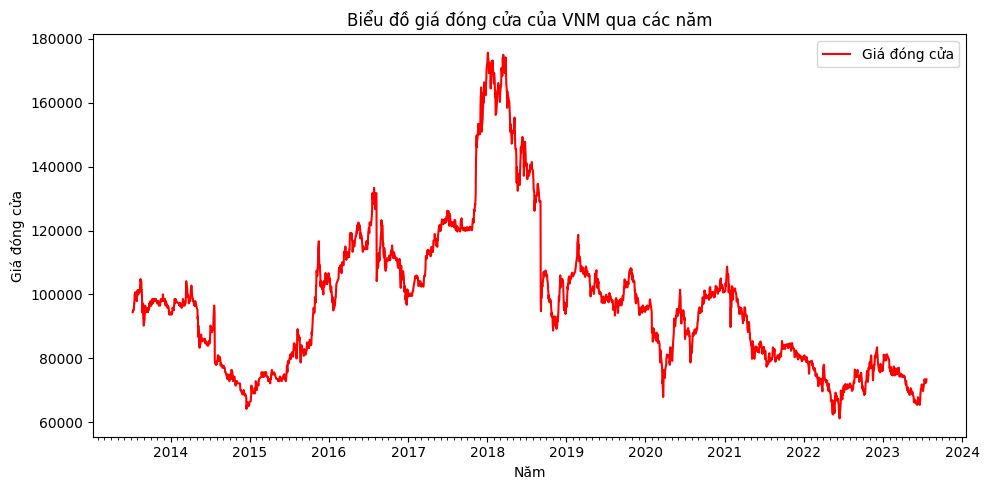

In [48]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngày')

# Chuyển đổi định dạng các cột giá thành số thực
df['Đóng cửa'] = df['Đóng cửa'].str.replace(',', '').astype(float)
df['Mở cửa'] = df['Mở cửa'].str.replace(',', '').astype(float)
df['Cao nhất'] = df['Cao nhất'].str.replace(',', '').astype(float)
df['Thấp nhất'] = df['Thấp nhất'].str.replace(',', '').astype(float)

# Lấy thông tin năm từ cột "Ngày"
df['Năm'] = df['Ngày'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngày'], df['Đóng cửa'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [49]:
df1 = pd.DataFrame(df,columns=['Ngày','Đóng cửa'])
df1.index = df1.Ngày
df1.drop('Ngày',axis=1,inplace=True)
df1

,Đóng cửa
Ngày,
2013-07-10,94444.0
2013-07-11,94444.0
2013-07-12,95139.0
2013-07-15,95139.0
2013-07-16,96528.0
...,...
2023-07-17,72300.0
2023-07-18,72400.0
2023-07-19,72600.0


In [50]:
#chia tập dữ liệu
data = df1.values
train_data = data[:1500]
test_data = data[1500:]

In [51]:
data

array([[94444.],
       [94444.],
       [95139.],
       ...,
       [72600.],
       [72700.],
       [73500.]])

In [65]:
#chuẩn hóa dữ liệu
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).reshape(train_data.shape)


In [66]:
# Convert to PyTorch tensors
x_train_tensor = torch.Tensor(train_data_scaled).view(-1, 1, train_data.shape[1])
y_train_tensor = torch.Tensor(y_train_scaled).view(-1, 1)

In [67]:
# Generator model
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (out, _) = self.lstm(x)
        out = self.linear(out[-1, :])  # Remove the middle index
        out = self.sigmoid(out)
        return out


In [68]:
# GAN model
class GAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, x):
        generated_data = self.generator(x)
        discriminator_output = self.discriminator(generated_data)
        return generated_data, discriminator_output

In [69]:
# Hyperparameters
input_size = train_data.shape[1]
hidden_size = 64
output_size = y_train_tensor.shape[1]
batch_size = 50
sequence_length = train_data.shape[0]


In [70]:
# Initialize models
generator = Generator(input_size, hidden_size, output_size)
discriminator = Discriminator(input_size, hidden_size)
gan_model = GAN(generator, discriminator)

In [71]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer_gan = optim.Adam(gan_model.parameters(), lr=0.001)

In [72]:
# Training loop
num_epochs = 400
for epoch in range(num_epochs):
    for batch in range(0, len(x_train_tensor), batch_size):
        x_batch = x_train_tensor[batch:batch+batch_size]
        y_batch = y_train_tensor[batch:batch+batch_size]

        # Generate fake data
        fake_data, disc_output_fake = gan_model(x_batch)

        # Calculate GAN loss
        gan_loss = criterion(disc_output_fake, torch.ones_like(disc_output_fake))

        # Update GAN parameters
        optimizer_gan.zero_grad()
        gan_loss.backward()
        optimizer_gan.step()

    # Print loss
    print(f'Epoch [{epoch}/{num_epochs}], GAN Loss: {gan_loss.item()}')

Epoch [0/400], GAN Loss: 0.062199290841817856
Epoch [1/400], GAN Loss: 0.006714303977787495
Epoch [2/400], GAN Loss: 0.0031131634023040533
Epoch [3/400], GAN Loss: 0.0021809262689203024
Epoch [4/400], GAN Loss: 0.001670145196840167
Epoch [5/400], GAN Loss: 0.0013342456659302115
Epoch [6/400], GAN Loss: 0.0010973273310810328
Epoch [7/400], GAN Loss: 0.0009222705848515034
Epoch [8/400], GAN Loss: 0.0007882840000092983
Epoch [9/400], GAN Loss: 0.0006823483272455633
Epoch [10/400], GAN Loss: 0.0005956277600489557
Epoch [11/400], GAN Loss: 0.0005192316020838916
Epoch [12/400], GAN Loss: 0.0004507722915150225
Epoch [13/400], GAN Loss: 0.0004022334178443998
Epoch [14/400], GAN Loss: 0.0003641314688138664
Epoch [15/400], GAN Loss: 0.0003319337556604296
Epoch [16/400], GAN Loss: 0.00030426838202401996
Epoch [17/400], GAN Loss: 0.00028024069615639746
Epoch [18/400], GAN Loss: 0.0002590157091617584
Epoch [19/400], GAN Loss: 0.0002400567173026502
Epoch [20/400], GAN Loss: 0.00022324430756270885
Ep